In [1]:

# Importing Libraries

import pandas as pd
import numpy as np
from datetime import datetime
import tqdm
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import spatial
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from prettytable import PrettyTable
from tqdm import tqdm
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")



In [2]:
x_train = pd.read_csv("../Data/train_1M_basic_feat.csv")
x_test = pd.read_csv("../Data/test_1M_basic_feat.csv")

In [3]:
y_train = x_train['class_label'].values
y_test = x_test['class_label'].values

In [20]:
x_train.columns

Index(['clicks', 'impressions', 'AdURL', 'AdId', 'AdvId', 'Depth', 'Pos',
       'QId', 'KeyId', 'TitleId', 'DescId', 'UId', 'CTR', 'RPosition', 'pCTR',
       'Gender', 'Age', 'QCount', 'TCount', 'DCount', 'KCount', 'mAdURL',
       'mAdId', 'mAdvId', 'mDepth', 'mPos', 'mQId', 'mKeyId', 'mTitleId',
       'mDescId', 'mUId', 'mRPosition', 'mGender', 'mAge', 'pAdURL', 'pAdId',
       'pAdvId', 'pDepth', 'pPos', 'pQId', 'pKeyId', 'pTitleId', 'pDescId',
       'pUId', 'pRPosition', 'pGender', 'pAge'],
      dtype='object')

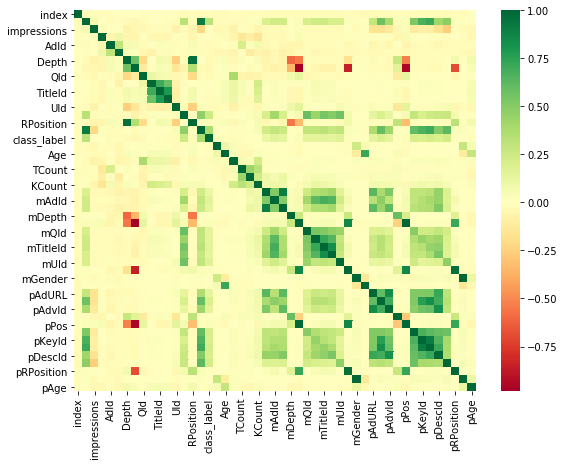

In [4]:
# Heatmap of correlation plot
plt.figure(figsize=(9,7))
sns.heatmap(x_train.corr(), cmap='RdYlGn')
plt.show()

In [4]:
x_train_o = x_train
x_train = x_train.drop('class_label', axis=1)
x_train = x_train.drop('index', axis=1)
x_train = x_train.drop('clicks', axis=1)
x_train = x_train.drop('impressions', axis=1)
x_train = x_train.drop('CTR', axis=1)
x_train = x_train.drop('pCTR', axis=1)

x_test_o = x_test
x_test = x_test.drop('class_label', axis=1)
x_test = x_test.drop('index', axis=1)
x_test = x_test.drop('clicks', axis=1)
x_test = x_test.drop('impressions', axis=1)
x_test = x_test.drop('CTR', axis=1)
x_test = x_test.drop('pCTR', axis=1)

print(x_train.shape)
print(x_test.shape)

(974891, 43)
(243708, 43)


In [5]:
# We also expand query’s tokens, title’s tokens, description’s tokens and keyword’s tokens into binary features.
# That is, if a token occurs in title, query, description or keyword, the corresponding value in the feature vector will be
# 1, or 0 otherwise



# one-hot encoding of Keyword feature.
train = [str (item) for item in x_train['KeyId']]
test = [str (item) for item in x_test['KeyId']]
keyword_vectorizer = CountVectorizer(binary=True)
bow_train_keyword = keyword_vectorizer.fit_transform(train)
bow_test_keyword = keyword_vectorizer.transform(test)

#train = [str (item) for item in x_train['Gender']]
#test = [str (item) for item in x_test['Gender']]
#user_gender_vectorizer = CountVectorizer(binary=True)
#bow_train_gender = user_gender_vectorizer.fit_transform(train)
#bow_test_gender = user_gender_vectorizer.transform(test)

#train = [str (item) for item in x_train['Age']]
#test = [str (item) for item in x_test['Age']]
#user_age_vectorizer = CountVectorizer(binary=True)
#bow_train_age = user_age_vectorizer.fit_transform(train)
#bow_test_age = user_age_vectorizer.transform(test)

train = [str (item) for item in x_train['QId']]
test = [str (item) for item in x_test['QId']]
query_vectorizer = CountVectorizer(binary=True)
bow_train_query = query_vectorizer.fit_transform(train)
bow_test_query = query_vectorizer.transform(test)

train = [str (item) for item in x_train['DescId']]
test = [str (item) for item in x_test['DescId']]
desc_vectorizer = CountVectorizer(binary=True)
bow_train_desc = desc_vectorizer.fit_transform(train)
bow_test_desc = desc_vectorizer.transform(test)

train = [str (item) for item in x_train['TitleId']]
test = [str (item) for item in x_test['TitleId']]
title_vectorizer = CountVectorizer(binary=True)
bow_train_title = title_vectorizer.fit_transform(train)
bow_test_title = title_vectorizer.transform(test)

train = [str (item) for item in x_train['AdId']]
test = [str (item) for item in x_test['AdId']]
add_vectorizer = CountVectorizer(binary=True)
bow_train_add = add_vectorizer.fit_transform(train)
bow_test_add = add_vectorizer.transform(test)

train = [str (item) for item in x_train['AdvId']]
test = [str (item) for item in x_test['AdvId']]
adv_vectorizer = CountVectorizer(binary=True)
bow_train_adv = adv_vectorizer.fit_transform(train)
bow_test_adv = adv_vectorizer.transform(test)

train = [str (item) for item in x_train['AdURL']]
test = [str (item) for item in x_test['AdURL']]
adurl_vectorizer = CountVectorizer(binary=True)
bow_train_adurl = adurl_vectorizer.fit_transform(train)
bow_test_adurl = adurl_vectorizer.transform(test)

In [6]:
x_train_sparse = csr_matrix(x_train.values)
train_data = hstack((x_train_sparse,bow_train_keyword,bow_train_query,bow_train_desc,bow_train_title,bow_train_add,bow_train_adv,bow_train_adurl))

x_test_sparse = csr_matrix(x_test.values)
test_data = hstack((x_test_sparse,bow_test_keyword,bow_test_query,bow_test_desc,bow_test_title,bow_test_add,bow_test_adv,bow_test_adurl))

In [7]:
train_normalized = normalize(train_data, axis=1)
test_normalized = normalize(test_data , axis=1)

In [8]:
def scoreClickAUC(num_clicks, num_impressions, predicted_ctr):
    """
    Calculates the area under the ROC curve (AUC) for click rates

    Parameters
    ----------
    num_clicks : a list containing the number of clicks

    num_impressions : a list containing the number of impressions

    predicted_ctr : a list containing the predicted click-through rates

    Returns
    ------- a under the ROC curve (AUC) for click rates
    """
     #sorting the values in descending order and store the index
    i_sorted = sorted(range(len(predicted_ctr)),key=lambda i: predicted_ctr[i],
                      reverse=True)
    auc_temp = 0.0
    click_sum = 0.0
    old_click_sum = 0.0
    no_click = 0.0
    no_click_sum = 0.0

    # treat all instances with the same predicted_ctr as coming from the same bucket
    last_ctr = predicted_ctr[i_sorted[0]] + 1.0

    for i in range(len(predicted_ctr)):
        # when prev_ctr value at i-1 not match with current ctr value at i
        if last_ctr != predicted_ctr[i_sorted[i]]: 
            auc_temp += (click_sum+old_click_sum) * no_click / 2.0        
            old_click_sum = click_sum
            no_click = 0.0
            last_ctr = predicted_ctr[i_sorted[i]] #updating the last ctr value 
        # Calculating negative sample as #impressions - #clicks    
        no_click += num_impressions[i_sorted[i]] - num_clicks[i_sorted[i]]
        no_click_sum += num_impressions[i_sorted[i]] - num_clicks[i_sorted[i]]
        # Calculating postive samples as # of clicks 
        click_sum += num_clicks[i_sorted[i]]
    auc_temp += (click_sum+old_click_sum) * no_click / 2.0
    auc = auc_temp / (click_sum * no_click_sum) # That is the scaling to a total area of 1
    return auc

In [9]:
# To plot confusion matrix.
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [0,1]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Best Estimator: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=25, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
************************************************************************************************************************
-------------------- Confusion matrix --------------------


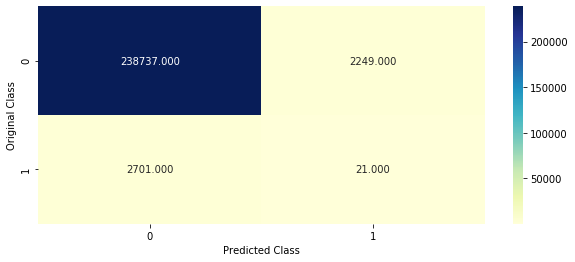

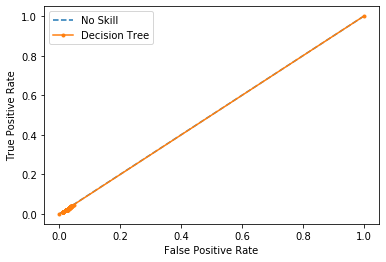

scoreKDD train AUC: 0.7649609906143584
scoreKDD test AUC: 0.48004066230007


In [10]:
cv_scores = []
tuned_parameters = {'max_depth': [25,40,75,100]}
#k = StratifiedKFold(n_splits=5)
random_dt = RandomizedSearchCV(DecisionTreeClassifier(), tuned_parameters, scoring = 'roc_auc', cv=2)
random_dt.fit(x_train,y_train)
print("Best Estimator: ")
model_dt = random_dt.best_estimator_
print(model_dt)
print("******"*20)
pred_train = random_dt.predict(x_train)
pred_test = random_dt.predict(x_test)

plot_confusion_matrix(pred_test,y_test)

ns_probs = [0 for _ in range(len(y_test))]
dt_probs_train = random_dt.predict_proba(x_train)
dt_probs_train = dt_probs_train[:, 1]
dt_probs_test = random_dt.predict_proba(x_test)
dt_probs_test = dt_probs_test[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs_test)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree')
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
    # show the plot
plt.show()
roc_auc_train = scoreClickAUC(x_train_o['clicks'],x_train_o['impressions'],dt_probs_train)
roc_auc_test = scoreClickAUC(x_test_o['clicks'],x_test_o['impressions'],dt_probs_test)
print("scoreKDD train AUC:", roc_auc_train)
print("scoreKDD test AUC:", roc_auc_test)

Random Forest

In [ ]:
cv_scores = []
tuned_parameters = {'n_estimators': [100,200,400,500], 'max_depth': [25,35,50,80]}
#k = StratifiedKFold(n_splits=5)
random_lr = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, scoring = 'roc_auc', cv=2)
random_lr.fit(x_train,y_train)
print("Best Estimator: ")
model_rdlr = random_lr.best_estimator_
print(model_rdlr)
print("******"*20)
pred_train = random_lr.predict(x_train)
pred_test = random_lr.predict(x_test)

plot_confusion_matrix(pred_test,y_test)

ns_probs = [0 for _ in range(len(y_test))]
rf_probs_train = random_lr.predict_proba(x_train)
rf_probs_train = rf_probs_train[:, 1]
rf_probs_test = random_lr.predict_proba(x_test)
rf_probs_test = rf_probs_test[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs_test)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
    # show the plot
plt.show()
roc_auc_train = scoreClickAUC(x_train['clicks'],x_train['impressions'],rf_probs_train)
roc_auc_test = scoreClickAUC(x_test['clicks'],x_test['impressions'],rf_probs_test)
print("scoreKDD train AUC:", roc_auc_train)
print("scoreKDD test AUC:", roc_auc_test)

XGBOOST

-------------------- Confusion matrix --------------------


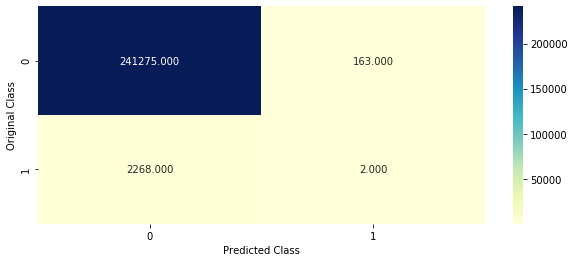

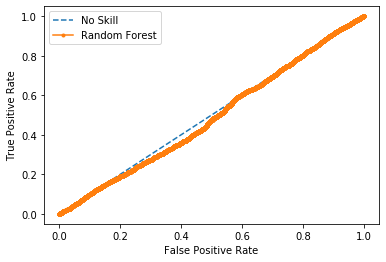

scoreKDD train AUC: 0.9410732214104738
scoreKDD test AUC: 0.4597566112257702
-------------------- Feature Importance --------------------


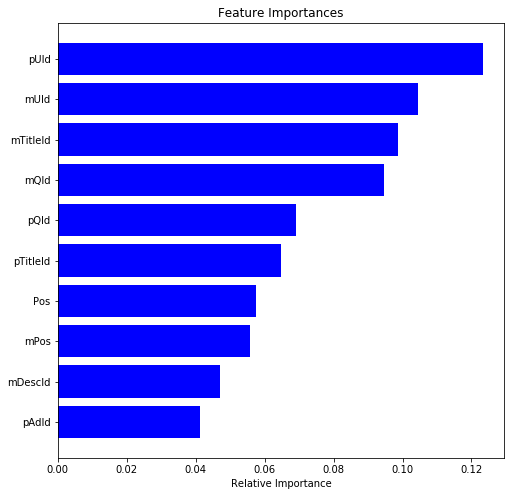

In [11]:

x_cfl=XGBClassifier(n_estimators=455,max_depth=3,learning_rate=0.1373,colsample_bytree=0.65,subsample=1)
x_cfl.fit(x_train,y_train,verbose=True)

predict_y = x_cfl.predict(x_train)

predict_y = x_cfl.predict(x_test)
plot_confusion_matrix(y_test, predict_y)

ns_probs = [0 for _ in range(len(y_test))]
xg_probs_train = x_cfl.predict_proba(x_train)
xg_probs_train = xg_probs_train[:, 1]
xg_probs_test = x_cfl.predict_proba(x_test)
xg_probs_test = xg_probs_test[:, 1]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs_test)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xg_fpr, xg_tpr, marker='.', label='Random Forest')
    # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    # show the legend
plt.legend()
    # show the plot
plt.show()
roc_auc_train = scoreClickAUC(x_train_o['clicks'],x_train_o['impressions'],xg_probs_train)
roc_auc_test = scoreClickAUC(x_test_o['clicks'],x_test_o['impressions'],xg_probs_test)
print("scoreKDD train AUC:", roc_auc_train)
print("scoreKDD test AUC:", roc_auc_test)

print("-"*20, "Feature Importance", "-"*20)

features = x_train.columns
importances = x_cfl.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(8,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
